In [2]:
!pip install kaggle

引入kaggle資料(ex: !kaggle competitions download -c machine-learningntut-2021-autumn-regression)

In [3]:
api_token = {"username":"kaggle_username","key":"kaggle_key"}
import json
import zipfile
import os
 
if not os.path.exists("/root/.kaggle"):
    os.makedirs("/root/.kaggle")
 
with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)
!chmod 600 /root/.kaggle/kaggle.json
 
if not os.path.exists("/kaggle"):
    os.makedirs("/kaggle")
os.chdir('/kaggle')
!kaggle competitions download -c machine-learningntut-2021-autumn-regression
 
!ls /kaggle

valid-v3.csv: Skipping, found more recently modified local copy (use --force to force download)
test-v3.csv: Skipping, found more recently modified local copy (use --force to force download)
train-v3.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
sampleSubmission.csv: Skipping, found more recently modified local copy (use --force to force download)
metadata.csv: Skipping, found more recently modified local copy (use --force to force download)
lab1-log      sampleSubmission.csv  test-v3.csv   train-v3.csv.zip
metadata.csv  submission_RELU.csv   train-v3.csv  valid-v3.csv


解壓縮train-v3.csv.zip

In [4]:
!unzip "/kaggle/train-v3.csv.zip" -d "/kaggle/"

Archive:  /kaggle/train-v3.csv.zip
replace /kaggle/train-v3.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: /kaggle/train-v3.csv    


In [ ]:
# 創建模型儲存目錄
model_dir = 'lab1-log/models/'
os.makedirs(model_dir)

In [6]:
# 輸入資料並查看
import pandas as pd 
import numpy as np
from sklearn import preprocessing

basepath = "/kaggle/"

train = pd.read_csv(basepath + "train-v3.csv")
valid = pd.read_csv(basepath + "valid-v3.csv")

In [7]:
#分類
train_xx = train.drop(['sale_month', 'sale_day', 'sale_yr','id','price'], axis = 1)
valid_xx = valid.drop(['sale_month', 'sale_day', 'sale_yr','id','price'], axis = 1)
train_yy = train[['price']].values
valid_yy = valid[['price']].values

In [8]:
#標準化數據
scale = preprocessing.StandardScaler()
x_train = scale.fit_transform(train_xx)
x_valid = scale.fit_transform(valid_xx)
y_train = scale.fit_transform(train_yy.reshape(-1, 1))
y_valid = scale.fit_transform(valid_yy.reshape(-1, 1))

In [9]:
# CNN 擴張 3維
x_train = np.expand_dims(x_train,axis=2)
x_valid = np.expand_dims(x_valid,axis=2)

In [44]:
# CNN 1D 
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Activation, Dropout, Conv1D, Flatten, MaxPooling1D
from keras.models import Sequential
def ss_dect(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )
model = Sequential()
model.add(Conv1D(16, 3,input_shape=(x_train.shape[1],x_train.shape[2]), activation='relu'))
model.add(Conv1D(16, 3, activation='relu',kernel_regularizer=keras.regularizers.l1_l2(l1=0.01, l2=0.01)))
# model.add(MaxPooling1D(2))
model.add(Conv1D(32, 3, activation='relu'))
model.add(Conv1D(32, 3, activation='relu'))
model.add(Conv1D(16, 3, activation='relu',kernel_regularizer=keras.regularizers.l1_l2(l1=0.01, l2=0.01)))
model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='linear'))
model.summary()
# 設定訓練使用的優化器、損失函數和指標函數
# model.compile(tf.keras.optimizers.Adam(0.001),loss=keras.losses.MeanSquaredError(),metrics=[keras.metrics.MeanAbsoluteError()])
model.compile(optimizer='adam', loss='mse', metrics=[ss_dect])

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_39 (Conv1D)          (None, 16, 9)             36        
                                                                 
 conv1d_40 (Conv1D)          (None, 14, 3)             84        
                                                                 
 conv1d_41 (Conv1D)          (None, 12, 3)             30        
                                                                 
 conv1d_42 (Conv1D)          (None, 10, 18)            180       
                                                                 
 conv1d_43 (Conv1D)          (None, 8, 36)             1980      
                                                                 
 flatten_8 (Flatten)         (None, 288)               0         
                                                                 
 dense_16 (Dense)            (None, 36)               

In [47]:
# TensorBoard回調函數會幫忙紀錄訓練資訊，並存成TensorBoard的紀錄檔
log_dir = os.path.join('lab1-log', 'model-1')
model_cbk = keras.callbacks.TensorBoard(log_dir=log_dir)
# ModelCheckpoint回調函數幫忙儲存網路模型，可以設定只儲存最好的模型，「monitor」表示被監測的數據，「mode」min則代表監測數據越小越好。
model_mckp = keras.callbacks.ModelCheckpoint(model_dir + '/Best-model-1.h5',
                                             monitor='loss',
                                             save_best_only=True,mode='min')

In [48]:
# 訓練網路模型
history = model.fit(x_train, y_train,  # 輸入訓練數據
               batch_size=8,  # 跟loss收斂還有訓練速度有關，
               epochs=300,  # 整個dataset訓練XX遍
               validation_data=(x_valid, y_valid),  # 驗證數據
               callbacks=[model_cbk, model_mckp]) 
# Tensorboard回調函數紀錄訓練過程，ModelCheckpoint回調函數儲存最好的模型

Epoch 1/300
1621/1621 [==============================] - 4s 2ms/step - loss: 0.1434 - ss_dect: 0.7481 - val_loss: 0.1766 - val_ss_dect: -58.3717
Epoch 2/300
1621/1621 [==============================] - 4s 3ms/step - loss: 0.1414 - ss_dect: 0.7408 - val_loss: 0.1602 - val_ss_dect: -136.8934
Epoch 3/300
1621/1621 [==============================] - 4s 2ms/step - loss: 0.1423 - ss_dect: 0.7465 - val_loss: 0.1617 - val_ss_dect: -857.2099
Epoch 4/300
1621/1621 [==============================] - 4s 3ms/step - loss: 0.1332 - ss_dect: 0.7535 - val_loss: 0.1540 - val_ss_dect: -2728.2944
Epoch 5/300
1621/1621 [==============================] - 4s 2ms/step - loss: 0.1453 - ss_dect: 0.7516 - val_loss: 0.1935 - val_ss_dect: -1448.8530
Epoch 6/300
1621/1621 [==============================] - 4s 2ms/step - loss: 0.1372 - ss_dect: 0.7503 - val_loss: 0.1554 - val_ss_dect: -625.2498
Epoch 7/300
1621/1621 [==============================] - 4s 2ms/step - loss: 0.1398 - ss_dect: 0.7501 - val_loss: 0.1549 - 

In [49]:
# CNN 訓練結果查看
scores = model.evaluate(x_valid,y_valid,verbose=0)
print('accuracy:%.2f%%'%(scores[1]*100))
predicted = model.predict(x_valid)
result =abs(np.mean(predicted - y_valid))
print(result)

accuracy:82.40%
0.04405788576324359


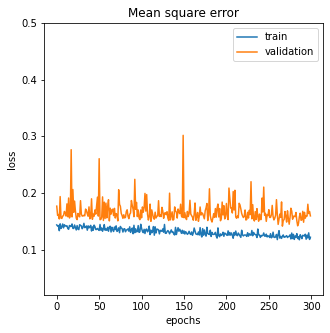

In [50]:
from matplotlib import pyplot as plt
plt.figure(figsize=(5, 5))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.ylim(0.02, 0.5)
plt.title('Mean square error')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')

In [53]:
test = pd.read_csv(basepath + "test-v3.csv")
# 存下id
id = test['id'].values
# 取出垃圾
test = test.drop(['sale_month', 'sale_day', 'sale_yr','id'], axis = 1)
#表準化數據
test = preprocessing.StandardScaler().fit_transform(test)
# 輸入模型
model = keras.models.load_model('lab1-log/models/Best-model-1.h5', custom_objects={'ss_dect': ss_dect})
pred = model.predict(test)
pred = scale.inverse_transform(pred)
id = list(id)
y_predict = np.squeeze(pred) # 降維 存值
mem = {"id":  id, "price" : y_predict}
mem_df = pd.DataFrame(mem)
mem_df.head()
mem_df.to_csv("submission_CNN.csv", index=False)